In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
import os
os.chdir('/content/drive/MyDrive/sign/Sign_Verif')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/sign/Sign_Verif/dataset',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 1416 images belonging to 2 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/sign/Sign_Verif/dataset',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 352 images belonging to 2 classes.


100%|██████████| 5/5 [01:04<00:00, 12.92s/it]


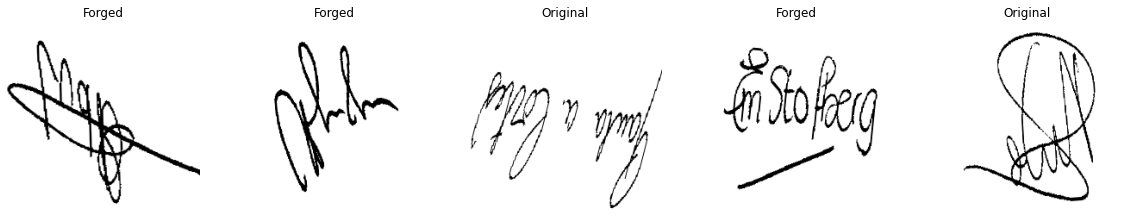

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Original')
    elif a[1] == 1:
        ax[i].set_title('Forged')
  

In [ ]:
base_model = VGG16(input_shape=(224,224,3), 
                   include_top=False,
                   weights="imagenet")

In [ ]:
for layer in base_model.layers:
    layer.trainable=False

In [ ]:

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
batch_normalization (BatchNo (None, 25088)             100352    
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
activation (Activation)      (None, 2048)              0

In [ ]:

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)
METRIC = tensorflow.keras.metrics.AUC(name = 'auc')

model.compile(loss='categorical_crossentropy',
              metrics=METRIC,
              optimizer=OPT)

In [ ]:

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 20,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/20
12/12 [==============================] - 32s 3s/step - loss: 0.7119 - auc: 0.6561 - val_loss: 92.6732 - val_auc: 0.6649

Epoch 00001: val_auc did not improve from 0.67715
Epoch 2/20
12/12 [==============================] - 31s 3s/step - loss: 0.7331 - auc: 0.6566 - val_loss: 8.5577 - val_auc: 0.6717

Epoch 00002: val_auc did not improve from 0.67715
Epoch 3/20
12/12 [==============================] - 31s 2s/step - loss: 0.7011 - auc: 0.6522 - val_loss: 5.8849 - val_auc: 0.6870

Epoch 00003: val_auc improved from 0.67715 to 0.68698, saving model to ./best_weights.hdf5
Epoch 4/20
12/12 [==============================] - 33s 3s/step - loss: 0.6751 - auc: 0.6759 - val_loss: 33.7616 - val_auc: 0.7868

Epoch 00004: val_auc improved from 0.68698 to 0.78684, saving model to ./best_weights.hdf5
Epoch 5/20
12/12 [==============================] - 31s 3s/step - loss: 0.6706 - auc: 0.6778 - val_loss: 432.3461 - val_auc: 0.6529

Epoch 00005: val_auc did not improve from 0.78684
Epoch 6/2

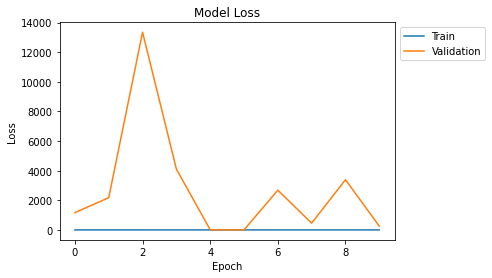

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

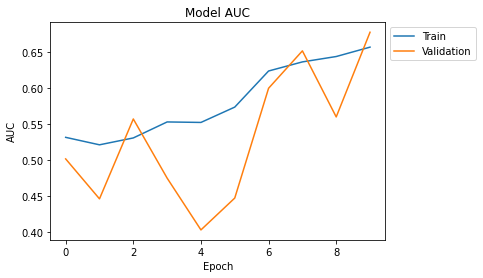

In [ ]:
plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()